## import libs

In [13]:
%matplotlib inline
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils import data as torchData
import torch.nn.functional as F
import os
import csv
import pickle
import numpy as np
import time
import util
import gc
import librosa
import librosa.display
import soundfile as sf
import matplotlib
import matplotlib.pyplot as plt


## Setting Hyperparams 

In [2]:
sequence_len = 101
input_size = 10
hidden_size= 257
num_layers = 2
num_classes = 1

num_epochs = 5
batch_size = 1
learning_rate = 0.001

In [3]:
inPath = "./dataset/accel_250"
inPath2 = "./dataset/spectrogram"
outPath = "./output_model"

## Data Load

In [4]:
class AudioLoader(torchData.Dataset):

    def __init__(self, inPathAccel, inPathAudio,isShuffle=False):

        files_accel = os.listdir(inPathAccel) 
        files_accel = [f for f in files_accel if os.path.splitext(f)[-1] == '.csv']
        files_accel.sort()
        files_audio = os.listdir(inPathAudio) 
        files_audio = [f for f in files_audio if os.path.splitext(f)[-1] == '.pickle']
        files_audio.sort()

        if isShuffle:
            random.shuffle(files_accel)

        self.inPathAccel = inPathAccel
        self.inPathAudio = inPathAudio
        self.len = len(files_accel)
        self.fileList_accel = files_accel[:self.len]
        self.fileList_audio = files_audio[:self.len]
        self.isShuffle = isShuffle

        print('len of dataset : ',self.len, len(files_audio))


    def __getitem__(self, idx):

        with open(os.path.join(self.inPathAccel,self.fileList_accel[idx]),'r',encoding='utf-8') as csvfile:
    
            rdr = csv.reader(csvfile)
            data_accel = [line for line in rdr]

            for idx2,each_line in enumerate(data_accel) :

                each_line = [float(i) for i in each_line]

                #x,y,z 3 axis -> sum(x,y,z) 1 axis and material property
                sum_3axis = np.sum(each_line[0:2])
                sum_3axis = (sum_3axis - 9) / 4.
                each_line = sum_3axis#[sum_3axis, each_line[-1]]

                data_accel[idx2] = each_line

            output_data = list()
            result = list()

            pointer = 0
            pointer_bool = True
            for i in range(0,sequence_len):

                if pointer < 9:#input_size-1
                    output_data = data_accel[:pointer+1]
                    output_data = np.pad(output_data, (input_size-pointer-1,0),'constant',constant_values=(0))
                else:
                    output_data = data_accel[pointer-9:pointer+1]

                if pointer_bool :
                    pointer += 2
                else:
                    pointer +=3

                pointer_bool =  not pointer_bool

                if i == sequence_len-1:
                    result.append(result[-1])
                else:
                    result.append(output_data)

            result = np.array(result)
            result = torch.from_numpy(result)

                #output_data = np.array(output_data)
                #print(output_data)
                #output_data = torch.from_numpy(output_data)

            #with open(os.path.join(self.inPathAudio, self.fileList_audio[idx]),'rb') as fs:

            with open(os.path.join(self.inPathAudio+'/'+self.fileList_audio[idx]),'rb') as fs:
                spectro = pickle.load(fs)
                #print(self.inPathAudio+'/'+self.fileList_audio[idx])
                spectro = np.array(spectro)
                spectro = np.log1p(spectro)
                spectro /= 2.2
                label = torch.from_numpy(spectro)
            return result, label #data_audio #input-label

    def __len__(self):
        return self.len


In [5]:
dataSet = AudioLoader(os.path.join(inPath),os.path.join(inPath2))

trainLoader = torchData.DataLoader(
    dataset = dataSet,
    batch_size = batch_size,
    shuffle = False
)

len of dataset :  201 201


# Architecture

In [6]:
class Haptic2AudioRNN(nn.Module):
    def __init__(self):
        super(Haptic2AudioRNN,self).__init__()
        self.model = nn.RNN(input_size =input_size, hidden_size = hidden_size,
                             num_layers = num_layers, batch_first = True)#, nonlinearity='relu'

    def forward(self, x, hidden):       
        
        x = x.view(batch_size, sequence_len, input_size)
        out, hidden = self.model(x, hidden)
        #hidden = hidden.detach()
        return hidden, out.view(-1, num_classes)

    def init_hidden(self):
        # Set initial states 
        return Variable(torch.zeros(num_layers,batch_size, hidden_size).type(torch.DoubleTensor))

    
def save(outPath, model, prefix = ''):

    timeText = util.getTime()

    if not prefix == '':

        prefix = prefix + '_'

    try:
        torch.save(model.cpu(), os.path.join(outPath, timeText + prefix+'rnn.model'))
        
    except:
        print('error : can\'t save model')

    else:
        print('successfully saved model - ', timeText + prefix)
        
        

        

In [7]:
# [-1,1] -> [0,1]
def denorm(x):
    out = (x + 1) / 2
    return out.clamp(0, 1)

In [49]:

print('Train Start...')

for i in range(2,3):
    
    model = Haptic2AudioRNN()
    model.double()
    learning_rate = 0.01 * (0.1**i)
    criterion = nn.KLDivLoss(size_average=False)#size_average = True
    optimizer = torch.optim.Adam(model.parameters(),lr = learning_rate)
    
    lossHistory = list()

    hidden= None
    
    
    for epoch in range(num_epochs):

        start_time = time.time()

        for idx, data in enumerate(trainLoader):#,0

            x, y = data
            x = Variable(x)

            y = Variable(y.type(torch.DoubleTensor), requires_grad = False)

            y = y.view(1,101,257)
            optimizer.zero_grad()
            loss = 0
            hidden = model.init_hidden()
            
            hidden, outputs = model.forward(x,hidden)
            #print(hidden)
            #print(outputs)
            #print("- outputs")
            #print(torch.mean(hidden))
            outputs = outputs.view(1,101,257)
            outputs = denorm(outputs)
            #print("- y")
            #util.printInfo(y)
            #print(F.softmax(y.view(101,257)))
            #util.printInfo(F.softmax(y.view(101,257)))
            #print(torch.sum(F.softmax(y.view(101,257))))
            #print(torch.sum(F.softmax(y.view(101,257))[0]))
            #print(torch.sum(F.softmax(y.view(101,257))[0][0]))
                #        util.printInfo(F.log_softmax(F.softmax(y.view(101*257))))
            #print(torch.sum(F.softmax(y.view(101,257))))

            #print("- outputs")
            #util.printInfo(outputs)
            #util.printInfo(F.softmax(outputs.view(101*257)))
            #util.printInfo(F.softmax(F.softmax(outputs.view(101*257))))

            #print(criterion(F.log_softmax(outputs.view(101,257)), F.softmax(y.view(101,257))))        
            #print((torch.mean((y -  outputs)**2)) )
            #print(criterion(F.log_softmax(F.softmax(outputs.view(101,257))), F.softmax(F.softmax(y.view(101,257)))))

            #print(criterion(F.log_softmax(outputs/torch.sum(outputs),dim=1),F.softmax(y/torch.sum(y),dim=1)))

            #view(101,257)
            loss = (torch.mean((y -  outputs)**2)) + criterion(F.log_softmax(outputs.view(101,257)), F.softmax(y.view(101,257)))
            #+ criterion(F.log_softmax(F.softmax(outputs.view(101,257))), F.softmax(F.softmax(y.view(101,257))))
    #        #        print(torch.sum(torch.pow((y -  outputs),2)) / (101*257))
            #loss = torch.sum(torch.pow((y -  outputs),2)) / 8000.0
            
            loss.backward(retain_graph=True)#
                    #retain_graph=True
            optimizer.step()

            #print(loss.data[0])

            if idx%130 == 0:
                util.printInfo(y)
                util.printInfo(outputs)
                print ('Epoch [%d/%d], Iter [%d/%d], Loss: %.8f'
                   %(epoch+1, num_epochs,idx+1, 201, loss.data[0]))
                print("loss1 :",torch.mean((y -  outputs)**2).data[0])
                print("loss2 :",criterion(F.log_softmax(outputs.view(101,257)), F.softmax(y.view(1,101,257))).data[0])
                print("--- %s seconds for epoch ---" % (time.time() - start_time))

            lossHistory.append((epoch,idx,loss.data[0]))
            gc.collect()


        save(outPath, model, 'epoch' + str(epoch))

    save(outPath, model, 'final')
    print(lossHistory)

Train Start...
mean:  0.013567387265637878 ,var: 0.0006245354757548559 ,max: 0.46245908737182617 ,min: 6.12684004863695e-07
mean:  0.5043609582533857 ,var: 0.01119853727708974 ,max: 0.8313936505829316 ,min: 0.21073412114930207
Epoch [1/5], Iter [1/201], Loss: 0.85685574
loss1 : 0.2529553381230945
loss2 : 0.6039004034131559
--- 0.1161661148071289 seconds for epoch ---


/home/dxplaboratory/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:62: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/home/dxplaboratory/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:62: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/home/dxplaboratory/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:79: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/home/dxplaboratory/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:79: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


mean:  0.01446230287283919 ,var: 0.0009960548139754174 ,max: 0.6309804320335388 ,min: 3.193254016764513e-08
mean:  0.16882587969511367 ,var: 0.0034966281848183294 ,max: 0.6218001458310374 ,min: 0.11174602229025232
Epoch [1/5], Iter [131/201], Loss: 0.06071859
loss1 : 0.026566209768269143
loss2 : 0.034152380657331796
--- 28.98632502555847 seconds for epoch ---


/home/dxplaboratory/anaconda3/lib/python3.5/site-packages/torch/serialization.py:158: UserWarning: Couldn't retrieve source code for container of type Haptic2AudioRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


successfully saved model -  1804021212_epoch0_
mean:  0.013567387265637878 ,var: 0.0006245354757548559 ,max: 0.46245908737182617 ,min: 6.12684004863695e-07
mean:  0.06084602143433001 ,var: 0.004964654514151957 ,max: 0.6060558517231466 ,min: 0.032102509016506076
Epoch [2/5], Iter [1/201], Loss: 0.02813007
loss1 : 0.006580951848949984
loss2 : 0.02154911578963768
--- 0.12830471992492676 seconds for epoch ---
mean:  0.01446230287283919 ,var: 0.0009960548139754174 ,max: 0.6309804320335388 ,min: 3.193254016764513e-08
mean:  0.040507216922094844 ,var: 0.004450455436395096 ,max: 0.5968830042355953 ,min: 0.013641400370267065
Epoch [2/5], Iter [131/201], Loss: 0.03378651
loss1 : 0.00425984207552431
loss2 : 0.02952666920609234
--- 29.350876569747925 seconds for epoch ---
successfully saved model -  1804021213_epoch1_
mean:  0.013567387265637878 ,var: 0.0006245354757548559 ,max: 0.46245908737182617 ,min: 6.12684004863695e-07
mean:  0.03631995839624478 ,var: 0.004306010295179432 ,max: 0.58257498305

In [50]:
def load(inPath, time = '', num = 1):

    try:
        #load the model files which are created lastly
        files = os.listdir(inPath)
        files = [f for f in files if os.path.splitext(f)[-1] == '.model']
        #files.sort(reverse = True)
        files.sort()
        #timeText = files[0][:10] + '_'
        #self.model = torch.load(os.path.join(inPath, timeText + prefix + 'rnn.model'))
        model = torch.load(os.path.join(inPath, files[-num]))
        #if torch.cuda.is_available():
        #    self.model.cuda()

    except:
        print('error : can\'t load model')

    else:
        #print('successfully loaded all model - ',timeText + prefix)
        print('successfully loaded all model - ',files[-num])


Test Strat...


/home/dxplaboratory/anaconda3/lib/python3.5/site-packages/librosa/core/spectrum.py:958: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(magphase(D)[0]) instead.
  warnings.warn('amplitude_to_db was called on complex input so phase '
/home/dxplaboratory/anaconda3/lib/python3.5/site-packages/librosa/display.py:657: UserWarning: Trying to display complex-valued input. Showing magnitude instead.
  warnings.warn('Trying to display complex-valued input. '


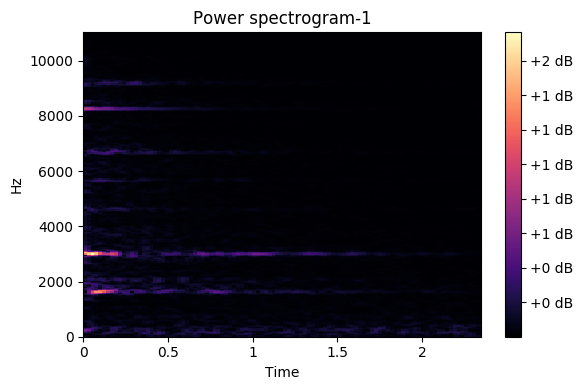

label
successfully loaded all model -  1804021215_final_rnn.model


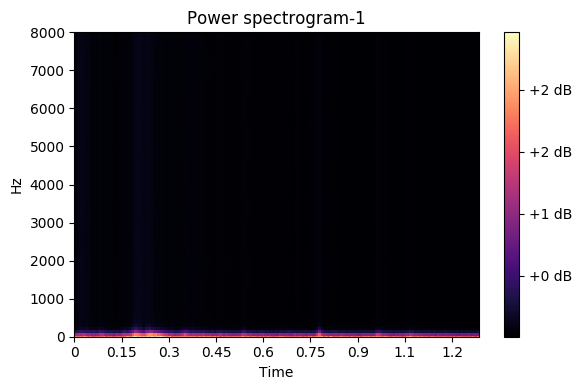

successfully loaded all model -  1804021215_epoch4_rnn.model


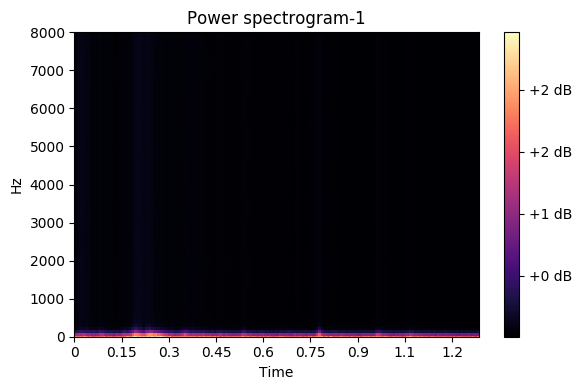

successfully loaded all model -  1804021214_epoch3_rnn.model


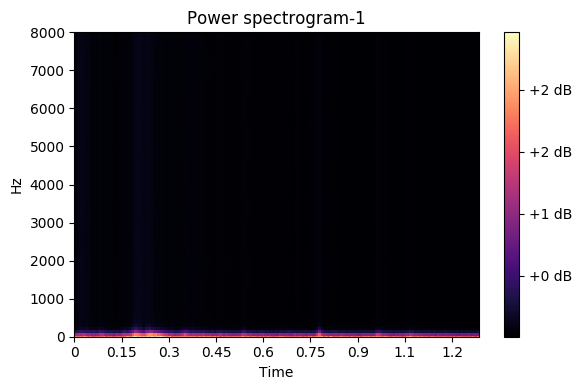

successfully loaded all model -  1804021214_epoch2_rnn.model


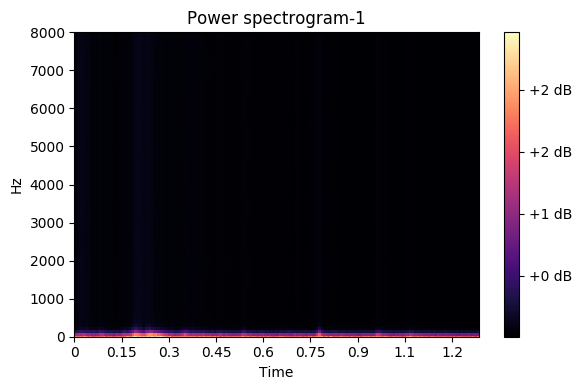

successfully loaded all model -  1804021213_epoch1_rnn.model


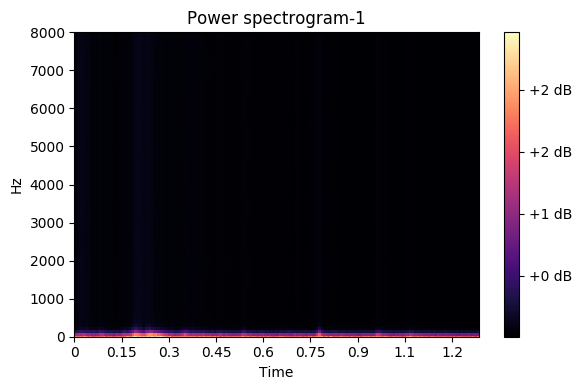

successfully loaded all model -  1804021212_epoch0_rnn.model


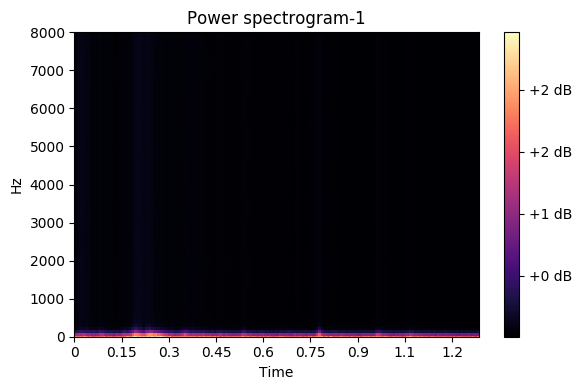

successfully loaded all model -  1804021147_final_rnn.model


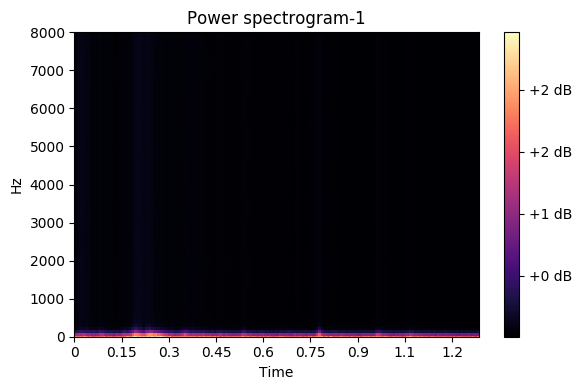

successfully loaded all model -  1804021147_epoch4_rnn.model


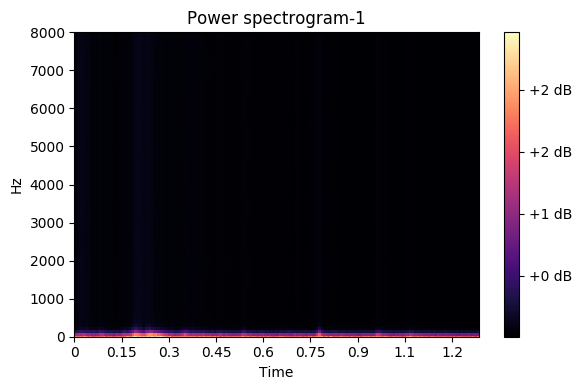

successfully loaded all model -  1804021146_epoch3_rnn.model


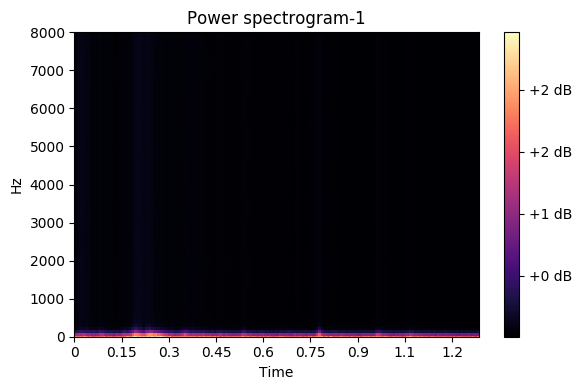

successfully loaded all model -  1804021145_epoch2_rnn.model


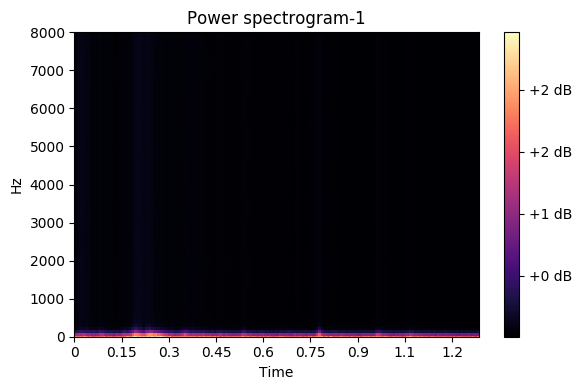

successfully loaded all model -  1804021145_epoch1_rnn.model


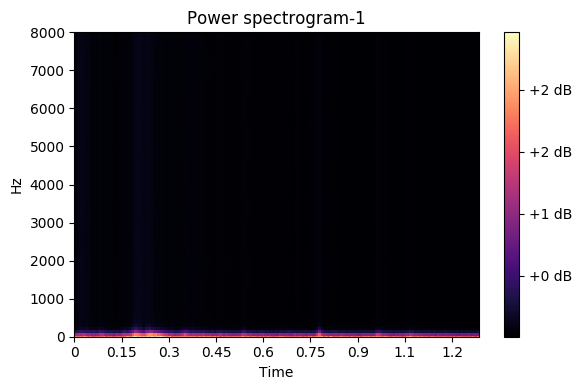

In [ ]:
print ('Test Strat...')
inPath = "./dataset/input_accel"
outPath = "./output_model"

y,sr = librosa.load("./dataset/audio/audio_steel_0.wav",sr= 16000)
stft_y = librosa.stft(y,n_fft= 512, hop_length = 80, win_length=400)
D = librosa.amplitude_to_db(stft_y,ref=np.max)
CQT = librosa.amplitude_to_db(librosa.cqt(y, sr=sr), ref=np.max)
librosa.display.specshow(stft_y,y_axis='linear', x_axis='time')
plt.title('Power spectrogram-1')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()
plt.show()
print("label")

timeText = util.getTime()
num = 11
for i in range(1,+num+1,1):
    load(outPath, num = i)
    for path, dirs, files in os.walk(inPath):

        for f in files:

            if os.path.splitext(f)[-1] == '.csv':

                with open(os.path.join(path,f), 'r') as csvfile:

                    rdr = csv.reader(csvfile)
                    data_accel = [line for line in rdr]

                    for idx2,each_line in enumerate(data_accel) :

                        each_line = [float(i) for i in each_line]

                        #x,y,z 3 axis -> sum(x,y,z) 1 axis and material property
                        sum_3axis = np.sum(each_line[0:2])
                        sum_3axis = (sum_3axis - 9) / 4.
                        each_line = sum_3axis#[sum_3axis, each_line[-1]]

                        data_accel[idx2] = each_line

                    output_data = list()
                    result = list()

                    pointer = 0
                    pointer_bool = True
                    for i in range(0,sequence_len):

                        if pointer < 9:#input_size-1
                            output_data = data_accel[:pointer+1]
                            output_data = np.pad(output_data, (input_size-pointer-1,0),'constant',constant_values=(0))
                        else:
                            output_data = data_accel[pointer-9:pointer+1]

                        if pointer_bool :
                            pointer += 2
                        else:
                            pointer +=3

                        pointer_bool =  not pointer_bool

                        if i == sequence_len-1:
                            result.append(result[-1])
                        else:
                            result.append(output_data)

                    result = np.array(result)
                    result = torch.from_numpy(result)
                    result = Variable(result)
                    
                    hidden = model.init_hidden()
                    hidden, outputs = model.forward(result,hidden)
                    
                    
                    outputs = outputs.view(1,101,257)
                    outputs = denorm(outputs)
                    
                    outputs = np.expm1(outputs.data.numpy() * 2.2)[0]
                    outputs = np.array(outputs)
                    
                    plt.title('Power spectrogram-1')
                    
                    librosa.display.specshow(outputs,y_axis='linear', x_axis='time',sr=16000,hop_length=80)
                    
                    plt.colorbar(format='%+2.0f dB')
                    plt.tight_layout()
                    plt.show()
                    
                    
                   # print(np.mean((stft_y -  outputs)**2))
                    
                    #util.printInfo(outputs)
                    #librosa.output.write_wav(self.inPath2+"/"+timeText+str(i)+"_"+os.path.splitext(f)[0]+".wav", outputs, sr = 16000, norm = True)
#                    sf.write(self.inPath2+"/"+timeText+str(i)+"_"+os.path.splitext(f)[0]+".wav", outputs, 16000)
                    #power for noise
#                            output = np.power(output,1.5)